In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
# from PIL import Image, ImageDraw
import pickle


pd.options.display.max_rows = 100

## Import Data

In [2]:
train = pd.read_csv('../data/Xtr.csv', sep = ",", header = None)
trainOutput = pd.read_csv('../data/Ytr.csv', sep = ",")
test = pd.read_csv('../data/Xte.csv', sep = ",", header = None)

In [3]:
train.drop(train.columns[len(train.columns)-1], axis=1, inplace=True)
test.drop(test.columns[len(test.columns)-1], axis=1, inplace=True)

In [4]:
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop('index',inplace=True,axis=1)

In [5]:
# images = []
# for index in range(len(combined)):
#     a = np.zeros((32,32, 3))
#     for j in range(32):
#         for k in range(32):
#             a[j,k] = (combined.iloc[index][j+32*k],combined.iloc[index][j+32*k+1024],combined.iloc[index][j+32*k+2048])
            
#     if index%(len(combined)/10) == 0:
#         print(index)
            
#     images.append(a)
#     pickle.dump(images, open('../pickles/images.pickle','wb'))

In [6]:
images = pickle.load(open("../pickles/images.pickle", 'rb'))

## Histogram of Gradients pour UN channel d'UNE image (faudra boucler)

In [7]:
def convolve2D(image, cvmatrix): #cvmatrix square, odd length and height matrix
    
    csize = int(cvmatrix.shape[0]/2)
    convolvedImage = np.array(image, dtype=complex)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            cvmatsubset = cvmatrix[max(0,csize-i):cvmatrix.shape[0]-max(0,(i+csize+1)-image.shape[0]),max(0,csize-j):cvmatrix.shape[1]-max(0,(j+csize+1)-image.shape[1])]
            imagesubset = image[max(0,i-csize):min(image.shape[0],i+csize+1),max(0,j-csize):min(image.shape[1],j+csize+1)]
#             print(i,j)
#             print(cvmatsubset)
#             print(imagesubset)
            convolvedImage[i,j] = np.sum(np.multiply(cvmatsubset,imagesubset))
#             print(convolvedImage[i,j])
#             print()
                
    return convolvedImage

In [8]:
def HOG(image, blockSize = 4, nbins = 9):
    scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                        [-10+0j, 0+ 0j, +10 +0j],
                        [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy

    grad = convolve2D(image, scharr)
    hist = np.zeros((8, 8, 9))
    blockSize = 4
    nbins = 9
    
    for i in range(8):
        for j in range(8):
            for case in np.nditer(grad[i*blockSize:(i+1)*blockSize, j*blockSize:(j+1)*blockSize]):
                hist[i,j,int(abs(nbins*((360+np.angle(case, deg = True))%360)/360))] += np.absolute(case)
                
    return hist, grad

### Test du HOG

In [9]:
from scipy import signal

def HOGscipy(image):
    scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                        [-10+0j, 0+ 0j, +10 +0j],
                        [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy

    grad = signal.convolve2d(image, scharr, boundary='symm', mode='same')
    blockSize = 4
    nbins = 9
    hist = np.zeros((int(image.shape[0]/blockSize), int(image.shape[1]/blockSize), nbins))

    for i in range(int(image.shape[0]/blockSize)):
        for j in range(int(image.shape[1]/blockSize)):
            for case in np.nditer(grad[i*blockSize:(i+1)*blockSize, j*blockSize:(j+1)*blockSize]):
                hist[i,j,int(abs(nbins*((360+np.angle(case, deg = True))%360)/360))] += np.absolute(case)
                
    return hist, grad

In [10]:
testImage = images[10][:,:,0]
hist, grad = HOG(testImage)
histsc, gradsc = HOGscipy(testImage)

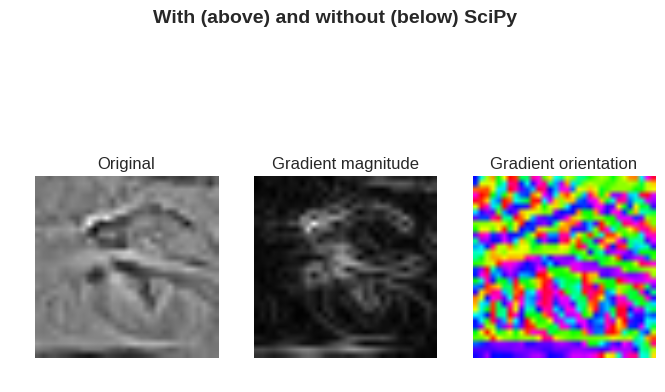

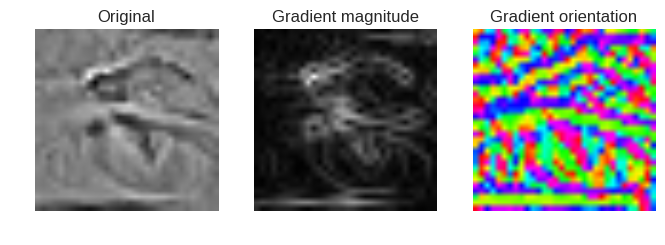

In [11]:
fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(1, 3)
ax_orig.imshow(testImage, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(gradsc), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(gradsc), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
fig.suptitle('With (above) and without (below) SciPy', fontsize=14, fontweight='bold')
fig.show()

fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(1, 3)
ax_orig.imshow(testImage, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_mag.imshow(np.absolute(grad), cmap='gray')
ax_mag.set_title('Gradient magnitude')
ax_mag.set_axis_off()
ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles
ax_ang.set_title('Gradient orientation')
ax_ang.set_axis_off()
fig.show()

## Creation of total pickle

In [12]:
def createHOG(images, blockSize = 4, nbins = 9):
    
    HOGfile = np.empty([nbins*images[0].shape[0]*2*3])
    for i in range(len(images)):
        line = np.empty([0])
        for r in range(3):
            hist, grad = HOG(images[i][:,:,r], blockSize = blockSize, nbins = nbins)
            line = np.append(line, np.ravel(hist))
        HOGfile = np.vstack((HOGfile, line))
        
    HOGfile = pd.DataFrame(HOGfile[1:]) #First line added I don't know why, but the other ones work

    pickle.dump(images, open('../pickles/HOG.pickle','wb'))
    HOGfile[:len(train)].to_csv('../pickles/HOG_train.csv', sep = ",", index=False, header = False)
    HOGfile[len(train):].to_csv('../pickles/HOG_test.csv', sep = ",", index=False, header = False)
    
    return HOGfile

In [13]:
hf = createHOG(images)